In [1]:
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# lenstronomy module import
import lenstronomy.Util.data_util as data_util
import lenstronomy.Util.util as util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
gauss = GaussianEllipse()
from astropy.cosmology import FlatLambdaCDM

In [2]:
DES_camera = {'read_noise': 7.,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.2637,  # scale (in arcseonds) of pixels
               'ccd_gain': 4.  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }
DES_g_band_obs = {'exposure_time': 90.,  # exposure time per image (in seconds)
                   'sky_brightness': 22.01,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 7,  # number of exposures that are combined
                   'seeing': 1.12,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }

numpix = 64
kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
kwargs_numerics = {'point_source_supersampling_factor': 1}

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

In [3]:
#Angular diameter in arc seconds
def angular_diameter(d, z):
    # d width of objetc, z redshift of the object, D angular diameter distance
    D = FlatLambdaCDM.angular_diameter_distance(cosmo, z)*1000 #in kpc
    delta = (648000*d)/(np.pi*D)

#Fundamental plane relations
def luminosity(velocity_dispersion):
    a = 2.0 #slope for V-band (for now)
    b = 5.8 #intercept for V-band (for now)
    L = 10**(a*np.log10(velocity_dispersion) + b)
    return L

def surface_brightness(lumino, effect_radius):
    mu = -2.5*np.log10(lumino/(2*np.pi*effect_radius**2))
    return(mu)

def effective_radius(vel_dispersion, luminosity):
    #[effective_radius] = kpc, [vel_dispersion]=km/s, []
    a = 1.4043 #orthogonal fit for g band
    b = 0.3045 #orthogonal fit for g band
    c = -8.8579 #orthogonal fit for g band
    delta_a = 0.02 #uncertainty due to random errors
    delta_b = 0.01 #uncertainty due to random errors
    logRe = (a*np.log10(vel_dispersion) + 2.5*b*np.log10(2*np.pi/luminosity) + c)/ (1-5*b)
    Re = 10**(logRe)
    mu_e = -2.5*np.log10(luminosity/(2*np.pi*Re**2))
    sig_scatter = (np.abs(np.log10(vel_dispersion))*delta_a**2 + np.abs(mu_e)*delta_b**2)**0.5
    scatter = np.random.randn()*sig_scatter
    return(Re + scatter)

## References for the fundamental plane relations, Fiber-Jackson relation and their implementation

https://github.com/jiwoncpark/baobab/blob/68879f75222aeff98267991189dad150c40c2784/baobab/bnn_priors/parameter_models.py#L73

https://arxiv.org/pdf/0810.4924.pdf

In [4]:
def funcion(z_lens, z_source1, z_source2, dispersion ,center_lens, center_source1, center_source2, i):

    kwargs_model_physical = {'lens_model_list': ['SIE'],  # list of lens models to be used
                          'lens_redshift_list': [z_lens],  # list of redshift of the deflections
                          'lens_light_model_list': ['SERSIC_ELLIPSE'],  # list of unlensed light models to be used
                          'source_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC'],  # list of extended source models to be used
                          'source_redshift_list': [z_source1, z_source2],  # list of redshfits of the sources in same order as source_light_model_list
                          'cosmo': cosmo,  # astropy.cosmology instance
                          'z_source': z_source2} # redshift of the default source (if not further specified by 'source_redshift_list') 
                           #and also serves as the redshift of lensed point sources}

    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)#, kwargs_numerics=kwargs_numerics)
    sim = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)#, kwargs_numerics=kwargs_numerics)
    imSim = sim.image_model_class(kwargs_numerics)

    kwargs_mass = [{'sigma_v': dispersion, 'center_x': center_lens[0], 'center_y': center_lens[1], 'e1': 0., 'e2': 0.}]
    kwargs_lens = sim.physical2lensing_conversion(kwargs_mass=kwargs_mass)
    luminosity_lens = luminosity(dispersion)
    effec_radius_lens = effective_radius(dispersion, luminosity_lens)
    surfa_bright_lens = surface_brightness(luminosity_lens, effec_radius_lens)

    #light
    kwargs_source_mag_g = [{'magnitude': 22, 'R_sersic': 0.3, 'n_sersic': 1.5, 'e1': 0., 'e2': 0., 'center_x': center_source1[0], 'center_y': center_source1[1]},
                      {'magnitude': 23, 'R_sersic': 0.3, 'n_sersic': 1.5, 'center_x': center_source2[0], 'center_y': center_source2[1]}]
    #luminosity, effective radius and surface brightness for the lens
    lumino = luminosity(dispersion)
    r_effective = effective_radius(dispersion, lumino)
    surf_bright = surface_brightness(lumino, r_effective)
    print(r_effective, surf_bright)
    kwargs_lens_light_mag_g = [{'magnitude': 20, 'R_sersic': .5, 'n_sersic': 2, 'e1': 0., 'e2': 0., 'center_x': center_lens[0], 'center_y': center_lens[1]}]
    kwargs_lens_light_g, kwargs_source_g , asdf= sim_g.magnitude2amplitude(kwargs_lens_light_mag_g, kwargs_source_mag_g)

    image_g = imSim.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g)
    image_g += sim.noise_for_model(model=image_g)

    plt.matshow(np.log10(image_g))
    plt.savefig('Image' + str(i) + '.png')

7.391509098071282e+24 97.94835899799844


/home/jimenagonzalez/software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in log10


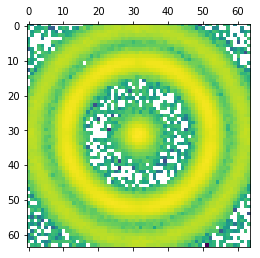

In [5]:
z_lens = .4
z_source1 = 1.
z_source2 = 3.5
dispersion = 600
center_lens = [0,0]
center_source1 = [0,0]
center_source2 = [0,0]
funcion(z_lens, z_source1, z_source2, dispersion, center_lens, center_source1, center_source2, 1)

In [6]:
vel = 600
lum = luminosity(vel)
r = effective_radius(vel, lum)
sur = surface_brightness(lum, r)
print(vel, r, sur)

600 7.391509098071282e+24 97.94835899799844
